In [7]:
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain_community.llms import LlamaCpp
from langchain.callbacks.manager import CallbackManager
import pandas as pd
from langchain import PromptTemplate
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from prompt_templates import *
import torch
import random
import warnings
import numpy as np
warnings.filterwarnings('ignore')


In [8]:
MODEL_PATH = { "Mixtral-8x-7b": "../models/mixtral-8x7b-instruct-v0.1.Q4_K_M.gguf",
               "Phi-2": "../models/phi-2.Q5_K_M.gguf",
               "Llama2-70b": "../models/llama2_70b_chat_uncensored.Q5_K_M.gguf",
               "Yi-34b": "../models/yi-34b-200k.Q5_K_M.gguf",
               "Dolphin-2.5": "../models/dolphin-2.5-mixtral-8x7b.Q5_K_M.gguf",
              }

#Set output file name
OUTPUT_EVALUATION = "../data/llm_mmlu.pkl"

#Filename output evaluation detailed
OUTPUT_EVALUATION_DETAILED = "../data/llm_prob_result_detailed_mmlu.pkl"

#Sampling rate determines how often a question is asked again if the answer format is wrong
MAX_SAMPLING_RATE = 5

#Set to 1 if you dont want to shuffle
NUM_OF_SHUFFLES = 5

#Parameter for changing the temperature of the model
TEMPERATURE = 1
FEW_SHOT_TEMPLATE = """
    The following are multiple choice questions (with answers) about network fundamentals, network access,
    security fundamentals, automation and programmability. Here are five examples:
    
    Question: Which two options are the best reasons to use an IPV4 private IP space? (Choose two.)
    
    Choices:
    A. to enable intra-enterprise communication
    B. to implement NAT
    C. to connect applications
    D. to conserve global address space
    E. to manage routing overhead
                                               
    Correct Answer: ['A','D']

    Question: Security Group Access requires which three syslog messages to be sent to Cisco ISE? (Choose three.)

    Choices:
    A. IOS-7-PROXY_DROP
    B. AP-1-AUTH_PROXY_DOS_ATTACK
    C. MKA-2-MACDROP
    D. AUTHMGR-5-MACMOVE
    E. ASA-6-CONNECT_BUILT
    F. AP-1-AUTH_PROXY_FALLBACK_REQ

    Correct Answer: ['B', 'D', 'F']

    Question: Which two authentication stores are supported to design a wireless network using PEAP EAP-MSCHAPv2 as the authentication method? (Choose two.)
    
    Choices:
    A. Microsoft Active Directory
    B. ACS
    C. LDAP
    D. RSA Secure-ID
    E. Certificate Server
    
    Correct Answer: ['A', 'B']

    Question: The corporate security policy requires multiple elements to be matched in an authorization policy. Which elements can be combined to meet the requirement?
    
    Choices:
    A. Device registration status and device activation status
    B. Network access device and time condition
    C. User credentials and server certificate
    D. Built-in profile and custom profile

    Correct Answer: ['B']

    Question: Which three posture states can be used for authorization rules? (Choose three.)
    
    Choices:
    A. unknown
    B. known
    C. noncompliant
    D. quarantined
    E. compliant
    F. no access
    G. limited

    Correct Answer: ['A', 'C', 'E']

    
    Please only response with the letter(s) of the correct answer like given in the example.       
    
    Now, answer the following question:
    Question: {Exam_Question}        
                    
    Choices:
    {Exam_Choices}
    """

FEW_SHOT_TEMPLATE_MMLU = """
    The following are multiple choice questions (with answers) about network fundamentals, network access,
    security fundamentals, automation and programmability. Here are five examples:
    
    Question: SHA-1 has a message digest of
    
    Choices:
    A. 160 bits
    B. 512 bits
    C. 628 bits
    D. 820 bits
                                               
    Correct Answer: ['A']

    Question: _____________ can modify data on your system – so that your system doesn’t run correctly or you can no longer access specific data, or it may even ask for ransom in order to give your access.
    
    Choices:
    A. "IM – Trojans"
    B. "Backdoor Trojans"
    C. "Trojan-Downloader"
    D. "Ransom Trojan"

    Correct Answer: ['D']

    Question: What is ethical hacking?

    Choices:
    A. ""Hacking" ethics so they justify unintended selfish behavior"
    B. "Hacking systems (e.g., during penetration testing) to expose vulnerabilities so they can be fixed, rather than exploited"
    C. "Hacking into systems run by those whose ethics you disagree with"
    D. "A slang term for rapid software development, e.g., as part of hackathons"
    
    Correct Answer: ['B']

    Question: Exploitation of the Heartbleed bug permits

    Choices:
    A. "overwriting cryptographic keys in memory"
    B. "a kind of code injection"
    C. "a read outside bounds of a buffer"
    D. "a format string attack"

    Correct Answer: ['C']

    Question: The ____________ is anything which your search engine cannot search.

    Choices:
    A. "Haunted web"
    B. "World Wide Web"
    C. "Surface web"
    D. "Deep Web"

    Correct Answer: ['D']

    
    Please only response with the letter(s) of the correct answer like given in the example.       
    
    Now, answer the following question:
    Question: {Exam_Question}        
                    
    Choices:
    {Exam_Choices}
    """



In [9]:
def extract_answer(answer):
    """Extracts the correct answers from the provided answer string.

    Args:
        answer: The answer string to extract the correct answers from.

    Returns:
        A list of correct answers (e.g., ['A', 'B']) if found, otherwise None. 
    """

    pattern = r"""
        ^\s*                
        Correct\s+Answer:\s+  
        \[                  
        ['ABCDET,]+\s*      
        \]                  
        \s*                 
    """
    match = re.search(pattern, answer, flags=re.VERBOSE)
    if match:
        # Extract the answer portion within the brackets
        answer_section = match.group(0).split('[')[1].split(']')[0]

        # Find individual answers (consider making this more robust if needed)
        correct_answers = answer_section.strip().split(',')
        return [ans.strip().strip("'") for ans in correct_answers]

    else:
        return None
    
def compare_answers(answerLLM, answer_exam):
    """Compares the extracted correct answers with the answers in answer_exam.

    Keyword arguments:
    answerLLM -- the list of answers extracted from the LLM answer
    answer_exam -- list of answers from the exam
    """
    # Convert answer_exam_list from letters to numbers
    answerLLM = [ord(answer) - 65 for answer in answerLLM]

    # Get number of correct answers in the exam
    num_of_correct_exam_answers = len(answer_exam)

    # Convert both lists to sets for efficient comparison
    answer_LLM_set = set(answerLLM)
    answer_exam_set = set(answer_exam)

    # Calculate the count of matching answers
    number_of_correct_llm_answers = len(answer_LLM_set.intersection(answer_exam_set))

    # Check if the number of answers given by the LLM is greater than the number of correct answers
    too_many_answ_given = False
    if len(answer_LLM_set) > num_of_correct_exam_answers:
        too_many_answ_given = True

    # Return a dictionary with the matching count and the number of correct answers
    return number_of_correct_llm_answers, too_many_answ_given

def format_choices_for_llm(choices):
    #Define the letters for the choices
    letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
    
    # Erstellen Sie den formatierten String
    formatted_choices = '\n'.join(f'{letters[i]}. {choice}' for i, choice in enumerate(choices))
    
    return formatted_choices

def evaluation_sampling(llm_answer, exam_Answers, num_of_correct_answer):
    """Analyse the answer given by the LLM and compare it with the exam answers.

    Keyword arguments:
    llm_answer -- the answer string given by the LLM
    exam_Answers -- the list of answers from the exam
    """

    answerLLM = extract_answer(llm_answer)
    if answerLLM is not None:
        num_of_correct_llm_Answers, too_many_answ = compare_answers(answerLLM, exam_Answers)
        if num_of_correct_llm_Answers == num_of_correct_answer and too_many_answ == False:
            answered_correctly = True
        else:
            answered_correctly = False 
        return num_of_correct_llm_Answers, answerLLM, too_many_answ, answered_correctly
    else:
         return -1


def evaluation(llm_output_dataframe):

    # Compute the number of total questions for each model
    number_of_questions = llm_output_dataframe.groupby('Model')['QuestionIndex'].count()
    
    #Number of fully correct answers given by the LLM
    correctly_answered = llm_output_dataframe.groupby('Model')['Answered_Correctly'].sum()

    #Number of incorrect answers given by the LLM
    incorrectly_answered = number_of_questions - correctly_answered

    #Amount of correct answers in the exam
    amount_correcct_exam_answers = llm_output_dataframe.groupby('Model')['NumberOfCorrectExamAnswers'].sum()

    #Amount of correct answers given by the LLM even if not fully correct
    amount_correcct_llm_answers = llm_output_dataframe.groupby('Model')['NumberOfCorrectLLMAnswers'].sum()
    
    #Calculation of Accuracy and Recall and f1 score
    accuracy = correctly_answered / number_of_questions
    accuracy_partial = amount_correcct_llm_answers / amount_correcct_exam_answers


    results_df = pd.DataFrame({
        'Number of Questions': number_of_questions,
        'Correctly Answered': correctly_answered,
        'Incorrectly Answered': incorrectly_answered,
        'Accuracy': accuracy,
        'Accuracy Partial': accuracy_partial,
    })

    results_df = results_df.reset_index()

    return results_df


def plot_evaluation(evaluation_df):
    """
    Plots evaluation metrics from a DataFrame containing columns:
        - 'Model'
        - 'Accuracy Mean', 'Accuracy Min', 'Accuracy Max'
        - 'Accuracy Partial Mean', 'Accuracy Partial Min', 'Accuracy Partial Max'
    """

    # Define a list of colors for the models
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    # Define bar width
    bar_width = 0.5  # Increase bar width for thicker bars

    # --- Subplot 1: Accuracy ---
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    for i, model in enumerate(evaluation_df['Model']):
        bars = axs[0].bar(i + bar_width * i, evaluation_df.loc[i, 'Accuracy Mean'], bar_width, 
                   yerr=[[abs(evaluation_df.loc[i, 'Accuracy Mean'] - evaluation_df.loc[i, 'Accuracy Min'])], [abs(evaluation_df.loc[i, 'Accuracy Max'] - evaluation_df.loc[i, 'Accuracy Mean'])]],
                   label=model, color=colors[i % len(colors)], capsize=5)

    axs[0].set_ylabel('Accuracy (%)')
    axs[0].set_title('Accuracy Mean with Error Bars (Max and Min)', fontsize=12)
    axs[0].set_xticks([i + bar_width * i for i in range(len(evaluation_df['Model']))])
    axs[0].set_xticklabels(evaluation_df['Model'], rotation=45, ha='right', fontsize=10)
    axs[0].legend()
    axs[0].set_ylim([0, 1])
    axs[0].yaxis.set_major_locator(mtick.MultipleLocator(0.1))
    axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    axs[0].grid(True, linestyle='dotted', axis='y')

    # --- Subplot 2: Partial Accuracy ---
    for i, model in enumerate(evaluation_df['Model']):
        bars = axs[1].bar(i + bar_width * i, evaluation_df.loc[i, 'Accuracy Partial Mean'], bar_width,
                   yerr=[[abs(evaluation_df.loc[i, 'Accuracy Partial Mean'] - evaluation_df.loc[i, 'Accuracy Partial Min'])], [abs(evaluation_df.loc[i, 'Accuracy Partial Max'] - evaluation_df.loc[i, 'Accuracy Partial Mean'])]],
                   label=model, color=colors[i % len(colors)], capsize=5)

    axs[1].set_ylabel('Accuracy Partial (%)')
    axs[1].set_title('Accuracy Partial Mean with Error Bars (Max and Min)', fontsize=12)
    axs[1].set_xticks([i + bar_width * i for i in range(len(evaluation_df['Model']))])
    axs[1].set_xticklabels(evaluation_df['Model'], rotation=45, ha='right', fontsize=10)
    axs[1].legend()
    axs[1].set_ylim([0, 1])
    axs[1].yaxis.set_major_locator(mtick.MultipleLocator(0.1))
    axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    axs[1].grid(True, linestyle='dotted', axis='y')

    fig.tight_layout(pad=1.2)  # Decrease padding for closer plots
    plt.show()

def calculate_model_statistics(df):
    """
    Calculates statistics for each model in the DataFrame.
    
    Args:
    df (DataFrame): Input DataFrame containing evaluation metrics for different models.
    
    Returns:
    DataFrame: New DataFrame containing calculated statistics for each model.
    """
    model_stats = []
    for model, group_df in df.groupby('Model'):
        model_stat = {
            'Model': model,
            'Accuracy Mean': group_df['Accuracy'].mean(),
            'Accuracy Max': group_df['Accuracy'].max(),
            'Accuracy Min': group_df['Accuracy'].min(),
            'Accuracy STD': group_df['Accuracy'].std(),
            'Accuracy Partial Mean': group_df['Accuracy Partial'].mean(),
            'Accuracy Partial Max': group_df['Accuracy Partial'].max(),
            'Accuracy Partial Min': group_df['Accuracy Partial'].min(),
            'Accuracy Partial STD': group_df['Accuracy Partial'].std()
        }
        model_stats.append(model_stat)
    
    return pd.DataFrame(model_stats)


def shuffle_choices_and_update_answer(choices, answer):
    # Erstellen Sie eine Liste von Indizes und mischen Sie sie
    indices = list(range(len(choices)))
    random.shuffle(indices)
    
    # Verwenden Sie die gemischten Indizes, um die Auswahlmöglichkeiten und die Antwort zu aktualisieren
    shuffled_choices = [choices[i] for i in indices]
    updated_answer = [indices.index(a) for a in answer]  # Entfernen Sie +1, um 0-basierte Indizes zu verwenden
    
    return shuffled_choices, updated_answer

llama_model_loader: loaded meta data with 26 key-value pairs and 995 tensors from ../models/mixtral-8x7b-instruct-v0.1.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mixtral-8x7b-instruct-v0.1
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:    

,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Mixtral-8x-7b,0,0,1,1,1.0,[C],[2],True,False
1,Mixtral-8x-7b,1,0,0,1,0.0,[C],[0],False,False
2,Mixtral-8x-7b,2,-1,0,1,-1.0,"\n Correct Answer: ['C', 'D']",[2],NaN,NaN
3,Mixtral-8x-7b,3,0,1,1,1.0,[A],[0],True,False
4,Mixtral-8x-7b,4,0,1,1,1.0,[A],[0],True,False
...,...,...,...,...,...,...,...,...,...,...
95,Mixtral-8x-7b,95,0,1,1,1.0,[A],[0],True,False
96,Mixtral-8x-7b,96,1,1,1,1.0,[A],[0],True,False
97,Mixtral-8x-7b,97,0,1,1,1.0,[C],[2],True,False
98,Mixtral-8x-7b,98,0,1,1,1.0,[C],[2],True,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Accuracy,Accuracy Partial,Model
0,100,71,29,0.71,0.73,Mixtral-8x-7b


,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Mixtral-8x-7b,0,2,1,1,1.0,[C],[2],True,False
1,Mixtral-8x-7b,1,1,0,1,0.0,[B],[2],False,False
2,Mixtral-8x-7b,2,0,1,1,1.0,[C],[2],True,False
3,Mixtral-8x-7b,3,0,1,1,1.0,[D],[3],True,False
4,Mixtral-8x-7b,4,0,1,1,1.0,[A],[0],True,False
...,...,...,...,...,...,...,...,...,...,...
95,Mixtral-8x-7b,95,0,0,1,0.0,[C],[1],False,False
96,Mixtral-8x-7b,96,0,1,1,1.0,[A],[0],True,False
97,Mixtral-8x-7b,97,0,1,1,1.0,[C],[2],True,False
98,Mixtral-8x-7b,98,0,1,1,1.0,[A],[0],True,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Accuracy,Accuracy Partial,Model
0,100,71,29,0.71,0.73,Mixtral-8x-7b
1,100,65,35,0.65,0.7,Mixtral-8x-7b


,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Mixtral-8x-7b,0,0,1,1,1.0,[C],[2],True,False
1,Mixtral-8x-7b,1,0,0,1,0.0,[D],[1],False,False
2,Mixtral-8x-7b,2,0,1,1,1.0,[D],[3],True,False
3,Mixtral-8x-7b,3,0,1,1,1.0,[D],[3],True,False
4,Mixtral-8x-7b,4,0,0,1,0.0,[A],[3],False,False
...,...,...,...,...,...,...,...,...,...,...
95,Mixtral-8x-7b,95,0,0,1,0.0,[A],[1],False,False
96,Mixtral-8x-7b,96,0,1,1,1.0,[B],[1],True,False
97,Mixtral-8x-7b,97,0,1,1,1.0,[C],[2],True,False
98,Mixtral-8x-7b,98,0,1,1,1.0,[A],[0],True,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Accuracy,Accuracy Partial,Model
0,100,71,29,0.71,0.73,Mixtral-8x-7b
1,100,65,35,0.65,0.7,Mixtral-8x-7b
2,100,65,35,0.65,0.68,Mixtral-8x-7b


,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Mixtral-8x-7b,0,1,1,1,1.0,[B],[1],True,False
1,Mixtral-8x-7b,1,1,0,1,0.0,[D],[0],False,False
2,Mixtral-8x-7b,2,2,1,1,1.0,[C],[2],True,False
3,Mixtral-8x-7b,3,0,1,1,1.0,[D],[3],True,False
4,Mixtral-8x-7b,4,0,0,1,0.0,[A],[1],False,False
...,...,...,...,...,...,...,...,...,...,...
95,Mixtral-8x-7b,95,4,1,1,1.0,[A],[0],True,False
96,Mixtral-8x-7b,96,4,0,1,0.0,[B],[2],False,False
97,Mixtral-8x-7b,97,0,1,1,1.0,[C],[2],True,False
98,Mixtral-8x-7b,98,0,1,1,1.0,[D],[3],True,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Accuracy,Accuracy Partial,Model
0,100,71,29,0.71,0.73,Mixtral-8x-7b
1,100,65,35,0.65,0.7,Mixtral-8x-7b
2,100,65,35,0.65,0.68,Mixtral-8x-7b
3,100,62,38,0.62,0.66,Mixtral-8x-7b


,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Mixtral-8x-7b,0,0,1,1,1.0,[C],[2],True,False
1,Mixtral-8x-7b,1,-1,0,1,-1.0,\n Answer: [D],[2],NaN,NaN
2,Mixtral-8x-7b,2,1,0,1,0.0,[B],[3],False,False
3,Mixtral-8x-7b,3,0,1,1,1.0,[C],[2],True,False
4,Mixtral-8x-7b,4,2,0,1,0.0,[D],[1],False,False
...,...,...,...,...,...,...,...,...,...,...
95,Mixtral-8x-7b,95,0,0,1,0.0,[A],[3],False,False
96,Mixtral-8x-7b,96,1,1,1,1.0,[B],[1],True,False
97,Mixtral-8x-7b,97,0,1,1,1.0,[C],[2],True,False
98,Mixtral-8x-7b,98,0,1,1,1.0,[B],[1],True,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Accuracy,Accuracy Partial,Model
0,100,71,29,0.71,0.73,Mixtral-8x-7b
1,100,65,35,0.65,0.7,Mixtral-8x-7b
2,100,65,35,0.65,0.68,Mixtral-8x-7b
3,100,62,38,0.62,0.66,Mixtral-8x-7b
4,100,63,37,0.63,0.67,Mixtral-8x-7b


llama_model_loader: loaded meta data with 20 key-value pairs and 325 tensors from ../models/phi-2.Q5_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = phi2
llama_model_loader: - kv   1:                               general.name str              = Phi2
llama_model_loader: - kv   2:                        phi2.context_length u32              = 2048
llama_model_loader: - kv   3:                      phi2.embedding_length u32              = 2560
llama_model_loader: - kv   4:                   phi2.feed_forward_length u32              = 10240
llama_model_loader: - kv   5:                           phi2.block_count u32              = 32
llama_model_loader: - kv   6:                  phi2.attention.head_count u32              = 32
llama_model_loader: - kv   7:               phi2.attention.head_count_kv u32             

,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Phi-2,0,0,0,1,0.0,[A],[2],False,False
1,Phi-2,1,0,0,1,0.0,[C],[0],False,False
2,Phi-2,2,1,0,1,0.0,[D],[2],False,False
3,Phi-2,3,0,1,1,1.0,[A],[0],True,False
4,Phi-2,4,2,1,1,1.0,[A],[0],True,False
...,...,...,...,...,...,...,...,...,...,...
95,Phi-2,95,0,0,1,0.0,[B],[0],False,False
96,Phi-2,96,0,1,1,1.0,[A],[0],True,False
97,Phi-2,97,0,0,1,0.0,[D],[2],False,False
98,Phi-2,98,0,1,1,1.0,[C],[2],True,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Accuracy,Accuracy Partial,Model
0,100,71,29,0.71,0.73,Mixtral-8x-7b
1,100,65,35,0.65,0.7,Mixtral-8x-7b
2,100,65,35,0.65,0.68,Mixtral-8x-7b
3,100,62,38,0.62,0.66,Mixtral-8x-7b
4,100,63,37,0.63,0.67,Mixtral-8x-7b
5,100,49,51,0.49,0.51,Phi-2


,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Phi-2,0,0,0,1,0.0,[D],[1],False,False
1,Phi-2,1,0,1,1,1.0,[B],[1],True,False
2,Phi-2,2,0,0,1,0.0,[B],[3],False,False
3,Phi-2,3,1,0,1,0.0,[A],[1],False,False
4,Phi-2,4,1,1,1,1.0,[A],[0],True,False
...,...,...,...,...,...,...,...,...,...,...
95,Phi-2,95,0,0,1,0.0,[A],[1],False,False
96,Phi-2,96,0,0,1,0.0,[B],[3],False,False
97,Phi-2,97,0,0,1,0.0,[B],[2],False,False
98,Phi-2,98,0,1,1,1.0,[C],[2],True,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Accuracy,Accuracy Partial,Model
0,100,71,29,0.71,0.73,Mixtral-8x-7b
1,100,65,35,0.65,0.7,Mixtral-8x-7b
2,100,65,35,0.65,0.68,Mixtral-8x-7b
3,100,62,38,0.62,0.66,Mixtral-8x-7b
4,100,63,37,0.63,0.67,Mixtral-8x-7b
5,100,49,51,0.49,0.51,Phi-2
6,100,52,48,0.52,0.54,Phi-2


,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Phi-2,0,0,0,1,0.0,[C],[0],False,False
1,Phi-2,1,0,1,1,1.0,[B],[1],True,False
2,Phi-2,2,0,0,1,0.0,[C],[1],False,False
3,Phi-2,3,0,0,1,0.0,[A],[1],False,False
4,Phi-2,4,1,0,1,0.0,[D],[2],False,False
...,...,...,...,...,...,...,...,...,...,...
95,Phi-2,95,1,1,1,1.0,[B],[1],True,False
96,Phi-2,96,0,1,1,1.0,[A],[0],True,False
97,Phi-2,97,0,1,1,1.0,[B],[1],True,False
98,Phi-2,98,0,1,1,1.0,[D],[3],True,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Accuracy,Accuracy Partial,Model
0,100,71,29,0.71,0.73,Mixtral-8x-7b
1,100,65,35,0.65,0.7,Mixtral-8x-7b
2,100,65,35,0.65,0.68,Mixtral-8x-7b
3,100,62,38,0.62,0.66,Mixtral-8x-7b
4,100,63,37,0.63,0.67,Mixtral-8x-7b
5,100,49,51,0.49,0.51,Phi-2
6,100,52,48,0.52,0.54,Phi-2
7,100,52,48,0.52,0.54,Phi-2


,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Phi-2,0,1,1,1,1.0,[B],[1],True,False
1,Phi-2,1,0,0,1,0.0,[B],[2],False,False
2,Phi-2,2,0,0,1,0.0,[D],[0],False,False
3,Phi-2,3,0,1,1,1.0,[D],[3],True,False
4,Phi-2,4,0,1,1,1.0,[B],[1],True,False
...,...,...,...,...,...,...,...,...,...,...
95,Phi-2,95,0,0,1,0.0,[A],[3],False,False
96,Phi-2,96,0,1,1,1.0,[A],[0],True,False
97,Phi-2,97,0,0,1,0.0,[A],[3],False,False
98,Phi-2,98,0,0,1,0.0,[C],[1],False,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Accuracy,Accuracy Partial,Model
0,100,71,29,0.71,0.73,Mixtral-8x-7b
1,100,65,35,0.65,0.7,Mixtral-8x-7b
2,100,65,35,0.65,0.68,Mixtral-8x-7b
3,100,62,38,0.62,0.66,Mixtral-8x-7b
4,100,63,37,0.63,0.67,Mixtral-8x-7b
5,100,49,51,0.49,0.51,Phi-2
6,100,52,48,0.52,0.54,Phi-2
7,100,52,48,0.52,0.54,Phi-2
8,100,51,49,0.51,0.52,Phi-2


,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Phi-2,0,0,0,1,0.0,[C],[1],False,False
1,Phi-2,1,0,0,1,0.0,[A],[3],False,False
2,Phi-2,2,0,0,1,0.0,[C],[3],False,False
3,Phi-2,3,1,0,1,0.0,[D],[0],False,False
4,Phi-2,4,0,1,1,1.0,[A],[0],True,False
...,...,...,...,...,...,...,...,...,...,...
95,Phi-2,95,0,0,1,0.0,[C],[0],False,False
96,Phi-2,96,1,0,1,0.0,[A],[3],False,False
97,Phi-2,97,0,1,1,1.0,[C],[2],True,False
98,Phi-2,98,0,1,1,1.0,[D],[3],True,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Accuracy,Accuracy Partial,Model
0,100,71,29,0.71,0.73,Mixtral-8x-7b
1,100,65,35,0.65,0.7,Mixtral-8x-7b
2,100,65,35,0.65,0.68,Mixtral-8x-7b
3,100,62,38,0.62,0.66,Mixtral-8x-7b
4,100,63,37,0.63,0.67,Mixtral-8x-7b
5,100,49,51,0.49,0.51,Phi-2
6,100,52,48,0.52,0.54,Phi-2
7,100,52,48,0.52,0.54,Phi-2
8,100,51,49,0.51,0.52,Phi-2
9,100,49,51,0.49,0.51,Phi-2


llama_model_loader: loaded meta data with 19 key-value pairs and 723 tensors from ../models/llama2_70b_chat_uncensored.Q5_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = jarradh_llama2_70b_chat_uncensored
llama_model_loader: - kv   2:                       llama.context_length u32              = 2048
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 8192
llama_model_loader: - kv   4:                          llama.block_count u32              = 80
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 28672
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                

,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Llama2-70b,0,0,1,1,1.0,[C],[2],True,False
1,Llama2-70b,1,0,0,1,0.0,[C],[0],False,False
2,Llama2-70b,2,0,1,1,1.0,[C],[2],True,False
3,Llama2-70b,3,1,1,1,1.0,[A],[0],True,False
4,Llama2-70b,4,0,0,1,0.0,[D],[0],False,False
...,...,...,...,...,...,...,...,...,...,...
95,Llama2-70b,95,3,1,1,1.0,[A],[0],True,False
96,Llama2-70b,96,0,1,1,1.0,[A],[0],True,False
97,Llama2-70b,97,1,1,1,1.0,[C],[2],True,False
98,Llama2-70b,98,0,1,1,1.0,[C],[2],True,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Accuracy,Accuracy Partial,Model
0,100,71,29,0.71,0.73,Mixtral-8x-7b
1,100,65,35,0.65,0.7,Mixtral-8x-7b
2,100,65,35,0.65,0.68,Mixtral-8x-7b
3,100,62,38,0.62,0.66,Mixtral-8x-7b
4,100,63,37,0.63,0.67,Mixtral-8x-7b
5,100,49,51,0.49,0.51,Phi-2
6,100,52,48,0.52,0.54,Phi-2
7,100,52,48,0.52,0.54,Phi-2
8,100,51,49,0.51,0.52,Phi-2
9,100,49,51,0.49,0.51,Phi-2


,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Llama2-70b,0,0,0,1,0.0,[C],[1],False,False
1,Llama2-70b,1,0,0,1,0.0,[C],[1],False,False
2,Llama2-70b,2,0,0,1,0.0,[A],[2],False,False
3,Llama2-70b,3,0,1,1,1.0,[B],[1],True,False
4,Llama2-70b,4,0,1,1,1.0,[B],[1],True,False
...,...,...,...,...,...,...,...,...,...,...
95,Llama2-70b,95,0,1,1,1.0,[C],[2],True,False
96,Llama2-70b,96,0,0,1,0.0,[A],[3],False,False
97,Llama2-70b,97,1,1,1,1.0,[A],[0],True,False
98,Llama2-70b,98,0,1,1,1.0,[B],[1],True,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Accuracy,Accuracy Partial,Model
0,100,71,29,0.71,0.73,Mixtral-8x-7b
1,100,65,35,0.65,0.7,Mixtral-8x-7b
2,100,65,35,0.65,0.68,Mixtral-8x-7b
3,100,62,38,0.62,0.66,Mixtral-8x-7b
4,100,63,37,0.63,0.67,Mixtral-8x-7b
5,100,49,51,0.49,0.51,Phi-2
6,100,52,48,0.52,0.54,Phi-2
7,100,52,48,0.52,0.54,Phi-2
8,100,51,49,0.51,0.52,Phi-2
9,100,49,51,0.49,0.51,Phi-2


,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Llama2-70b,0,0,0,1,0.0,[C],[0],False,False
1,Llama2-70b,1,0,0,1,0.0,[D],[0],False,False
2,Llama2-70b,2,0,1,1,1.0,[B],[1],True,False
3,Llama2-70b,3,2,0,1,0.0,[C],[3],False,False
4,Llama2-70b,4,1,1,1,1.0,[D],[3],True,False
...,...,...,...,...,...,...,...,...,...,...
95,Llama2-70b,95,2,1,1,1.0,"[A, C]",[2],False,True
96,Llama2-70b,96,0,0,1,0.0,[A],[1],False,False
97,Llama2-70b,97,0,1,1,1.0,[D],[3],True,False
98,Llama2-70b,98,0,1,1,1.0,[A],[0],True,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Accuracy,Accuracy Partial,Model
0,100,71,29,0.71,0.73,Mixtral-8x-7b
1,100,65,35,0.65,0.7,Mixtral-8x-7b
2,100,65,35,0.65,0.68,Mixtral-8x-7b
3,100,62,38,0.62,0.66,Mixtral-8x-7b
4,100,63,37,0.63,0.67,Mixtral-8x-7b
5,100,49,51,0.49,0.51,Phi-2
6,100,52,48,0.52,0.54,Phi-2
7,100,52,48,0.52,0.54,Phi-2
8,100,51,49,0.51,0.52,Phi-2
9,100,49,51,0.49,0.51,Phi-2


,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Llama2-70b,0,0,1,1,1.0,[D],[3],True,False
1,Llama2-70b,1,1,0,1,0.0,[A],[1],False,False
2,Llama2-70b,2,0,1,1,1.0,[C],[2],True,False
3,Llama2-70b,3,0,1,1,1.0,[C],[2],True,False
4,Llama2-70b,4,0,0,1,0.0,[D],[1],False,False
...,...,...,...,...,...,...,...,...,...,...
95,Llama2-70b,95,1,0,1,0.0,[C],[3],False,False
96,Llama2-70b,96,0,0,1,0.0,[D],[0],False,False
97,Llama2-70b,97,0,1,1,1.0,[D],[3],True,False
98,Llama2-70b,98,0,1,1,1.0,[C],[2],True,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Accuracy,Accuracy Partial,Model
0,100,71,29,0.71,0.73,Mixtral-8x-7b
1,100,65,35,0.65,0.7,Mixtral-8x-7b
2,100,65,35,0.65,0.68,Mixtral-8x-7b
3,100,62,38,0.62,0.66,Mixtral-8x-7b
4,100,63,37,0.63,0.67,Mixtral-8x-7b
5,100,49,51,0.49,0.51,Phi-2
6,100,52,48,0.52,0.54,Phi-2
7,100,52,48,0.52,0.54,Phi-2
8,100,51,49,0.51,0.52,Phi-2
9,100,49,51,0.49,0.51,Phi-2


,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Llama2-70b,0,0,1,1,1.0,[B],[1],True,False
1,Llama2-70b,1,0,1,1,1.0,[D],[3],True,False
2,Llama2-70b,2,0,1,1,1.0,[A],[0],True,False
3,Llama2-70b,3,0,1,1,1.0,[C],[2],True,False
4,Llama2-70b,4,0,1,1,1.0,[A],[0],True,False
...,...,...,...,...,...,...,...,...,...,...
95,Llama2-70b,95,0,0,1,0.0,[B],[2],False,False
96,Llama2-70b,96,0,0,1,0.0,[D],[2],False,False
97,Llama2-70b,97,0,1,1,1.0,[A],[0],True,False
98,Llama2-70b,98,0,1,1,1.0,[B],[1],True,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Accuracy,Accuracy Partial,Model
0,100,71,29,0.71,0.73,Mixtral-8x-7b
1,100,65,35,0.65,0.7,Mixtral-8x-7b
2,100,65,35,0.65,0.68,Mixtral-8x-7b
3,100,62,38,0.62,0.66,Mixtral-8x-7b
4,100,63,37,0.63,0.67,Mixtral-8x-7b
5,100,49,51,0.49,0.51,Phi-2
6,100,52,48,0.52,0.54,Phi-2
7,100,52,48,0.52,0.54,Phi-2
8,100,51,49,0.51,0.52,Phi-2
9,100,49,51,0.49,0.51,Phi-2


llama_model_loader: loaded meta data with 22 key-value pairs and 543 tensors from ../models/yi-34b-200k.Q5_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = 01-ai_yi-34b-200k
llama_model_loader: - kv   2:                       llama.context_length u32              = 200000
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 7168
llama_model_loader: - kv   4:                          llama.block_count u32              = 60
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 20480
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 llama.attention.head

,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Yi-34b,0,0,0,1,0.0,[B],[2],False,False
1,Yi-34b,1,0,0,1,0.0,[C],[0],False,False
2,Yi-34b,2,0,1,1,1.0,[C],[2],True,False
3,Yi-34b,3,0,0,1,0.0,[C],[0],False,False
4,Yi-34b,4,0,1,1,1.0,[A],[0],True,False
...,...,...,...,...,...,...,...,...,...,...
95,Yi-34b,95,0,0,1,0.0,[D],[0],False,False
96,Yi-34b,96,0,1,1,1.0,[A],[0],True,False
97,Yi-34b,97,0,1,1,1.0,[C],[2],True,False
98,Yi-34b,98,0,1,1,1.0,[C],[2],True,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Accuracy,Accuracy Partial,Model
0,100,71,29,0.71,0.73,Mixtral-8x-7b
1,100,65,35,0.65,0.7,Mixtral-8x-7b
2,100,65,35,0.65,0.68,Mixtral-8x-7b
3,100,62,38,0.62,0.66,Mixtral-8x-7b
4,100,63,37,0.63,0.67,Mixtral-8x-7b
5,100,49,51,0.49,0.51,Phi-2
6,100,52,48,0.52,0.54,Phi-2
7,100,52,48,0.52,0.54,Phi-2
8,100,51,49,0.51,0.52,Phi-2
9,100,49,51,0.49,0.51,Phi-2


,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Yi-34b,0,0,0,1,0.0,[D],[0],False,False
1,Yi-34b,1,0,0,1,0.0,[D],[2],False,False
2,Yi-34b,2,0,0,1,0.0,[C],[1],False,False
3,Yi-34b,3,0,0,1,0.0,[D],[1],False,False
4,Yi-34b,4,0,1,1,1.0,[B],[1],True,False
...,...,...,...,...,...,...,...,...,...,...
95,Yi-34b,95,0,0,1,0.0,[C],[0],False,False
96,Yi-34b,96,0,0,1,0.0,[D],[2],False,False
97,Yi-34b,97,0,0,1,0.0,[D],[0],False,False
98,Yi-34b,98,0,0,1,0.0,[D],[2],False,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Accuracy,Accuracy Partial,Model
0,100,71,29,0.71,0.73,Mixtral-8x-7b
1,100,65,35,0.65,0.7,Mixtral-8x-7b
2,100,65,35,0.65,0.68,Mixtral-8x-7b
3,100,62,38,0.62,0.66,Mixtral-8x-7b
4,100,63,37,0.63,0.67,Mixtral-8x-7b
5,100,49,51,0.49,0.51,Phi-2
6,100,52,48,0.52,0.54,Phi-2
7,100,52,48,0.52,0.54,Phi-2
8,100,51,49,0.51,0.52,Phi-2
9,100,49,51,0.49,0.51,Phi-2


,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Yi-34b,0,0,0,1,0.0,[A],[1],False,False
1,Yi-34b,1,0,1,1,1.0,[A],[0],True,False
2,Yi-34b,2,0,0,1,0.0,[D],[1],False,False
3,Yi-34b,3,0,0,1,0.0,[D],[0],False,False
4,Yi-34b,4,0,1,1,1.0,[D],[3],True,False
...,...,...,...,...,...,...,...,...,...,...
95,Yi-34b,95,0,0,1,0.0,[C],[0],False,False
96,Yi-34b,96,0,1,1,1.0,[B],[1],True,False
97,Yi-34b,97,0,1,1,1.0,[C],[2],True,False
98,Yi-34b,98,1,0,1,0.0,[B],[2],False,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Accuracy,Accuracy Partial,Model
0,100,71,29,0.71,0.73,Mixtral-8x-7b
1,100,65,35,0.65,0.7,Mixtral-8x-7b
2,100,65,35,0.65,0.68,Mixtral-8x-7b
3,100,62,38,0.62,0.66,Mixtral-8x-7b
4,100,63,37,0.63,0.67,Mixtral-8x-7b
5,100,49,51,0.49,0.51,Phi-2
6,100,52,48,0.52,0.54,Phi-2
7,100,52,48,0.52,0.54,Phi-2
8,100,51,49,0.51,0.52,Phi-2
9,100,49,51,0.49,0.51,Phi-2


,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Yi-34b,0,0,0,1,0.0,[D],[1],False,False
1,Yi-34b,1,0,1,1,1.0,[B],[1],True,False
2,Yi-34b,2,0,1,1,1.0,[D],[3],True,False
3,Yi-34b,3,0,0,1,0.0,[A],[2],False,False
4,Yi-34b,4,0,0,1,0.0,[B],[3],False,False
...,...,...,...,...,...,...,...,...,...,...
95,Yi-34b,95,1,0,1,0.0,[B],[2],False,False
96,Yi-34b,96,0,1,1,1.0,[A],[0],True,False
97,Yi-34b,97,0,1,1,1.0,[C],[2],True,False
98,Yi-34b,98,0,0,1,0.0,[D],[2],False,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Accuracy,Accuracy Partial,Model
0,100,71,29,0.71,0.73,Mixtral-8x-7b
1,100,65,35,0.65,0.7,Mixtral-8x-7b
2,100,65,35,0.65,0.68,Mixtral-8x-7b
3,100,62,38,0.62,0.66,Mixtral-8x-7b
4,100,63,37,0.63,0.67,Mixtral-8x-7b
5,100,49,51,0.49,0.51,Phi-2
6,100,52,48,0.52,0.54,Phi-2
7,100,52,48,0.52,0.54,Phi-2
8,100,51,49,0.51,0.52,Phi-2
9,100,49,51,0.49,0.51,Phi-2


,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Yi-34b,0,0,1,1,1.0,[C],[2],True,False
1,Yi-34b,1,0,1,1,1.0,[A],[0],True,False
2,Yi-34b,2,0,0,1,0.0,[B],[0],False,False
3,Yi-34b,3,0,0,1,0.0,[B],[0],False,False
4,Yi-34b,4,0,0,1,0.0,[D],[0],False,False
...,...,...,...,...,...,...,...,...,...,...
95,Yi-34b,95,0,0,1,0.0,[C],[0],False,False
96,Yi-34b,96,0,0,1,0.0,[D],[1],False,False
97,Yi-34b,97,0,0,1,0.0,[A],[1],False,False
98,Yi-34b,98,0,0,1,0.0,[B],[3],False,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Accuracy,Accuracy Partial,Model
0,100,71,29,0.71,0.73,Mixtral-8x-7b
1,100,65,35,0.65,0.7,Mixtral-8x-7b
2,100,65,35,0.65,0.68,Mixtral-8x-7b
3,100,62,38,0.62,0.66,Mixtral-8x-7b
4,100,63,37,0.63,0.67,Mixtral-8x-7b
5,100,49,51,0.49,0.51,Phi-2
6,100,52,48,0.52,0.54,Phi-2
7,100,52,48,0.52,0.54,Phi-2
8,100,51,49,0.51,0.52,Phi-2
9,100,49,51,0.49,0.51,Phi-2


llama_model_loader: loaded meta data with 25 key-value pairs and 995 tensors from ../models/dolphin-2.5-mixtral-8x7b.Q5_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = ehartford_dolphin-2.5-mixtral-8x7b
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:        

,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Dolphin-2.5,0,0,1,1,1.0,[C],[2],True,False
1,Dolphin-2.5,1,0,1,1,1.0,[A],[0],True,False
2,Dolphin-2.5,2,0,1,1,1.0,[C],[2],True,False
3,Dolphin-2.5,3,2,1,1,1.0,[A],[0],True,False
4,Dolphin-2.5,4,0,0,1,0.0,[B],[0],False,False
...,...,...,...,...,...,...,...,...,...,...
95,Dolphin-2.5,95,0,1,1,1.0,[A],[0],True,False
96,Dolphin-2.5,96,0,1,1,1.0,[A],[0],True,False
97,Dolphin-2.5,97,0,1,1,1.0,[C],[2],True,False
98,Dolphin-2.5,98,0,1,1,1.0,[C],[2],True,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Accuracy,Accuracy Partial,Model
0,100,71,29,0.71,0.73,Mixtral-8x-7b
1,100,65,35,0.65,0.7,Mixtral-8x-7b
2,100,65,35,0.65,0.68,Mixtral-8x-7b
3,100,62,38,0.62,0.66,Mixtral-8x-7b
4,100,63,37,0.63,0.67,Mixtral-8x-7b
5,100,49,51,0.49,0.51,Phi-2
6,100,52,48,0.52,0.54,Phi-2
7,100,52,48,0.52,0.54,Phi-2
8,100,51,49,0.51,0.52,Phi-2
9,100,49,51,0.49,0.51,Phi-2


,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Dolphin-2.5,0,1,1,1,1.0,[D],[3],True,False
1,Dolphin-2.5,1,0,0,1,0.0,[B],[3],False,False
2,Dolphin-2.5,2,0,1,1,1.0,[A],[0],True,False
3,Dolphin-2.5,3,0,1,1,1.0,[D],[3],True,False
4,Dolphin-2.5,4,0,0,1,0.0,[B],[2],False,False
...,...,...,...,...,...,...,...,...,...,...
95,Dolphin-2.5,95,0,1,1,1.0,[D],[3],True,False
96,Dolphin-2.5,96,0,1,1,1.0,[C],[2],True,False
97,Dolphin-2.5,97,0,1,1,1.0,[C],[2],True,False
98,Dolphin-2.5,98,0,1,1,1.0,[B],[1],True,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Accuracy,Accuracy Partial,Model
0,100,71,29,0.71,0.73,Mixtral-8x-7b
1,100,65,35,0.65,0.7,Mixtral-8x-7b
2,100,65,35,0.65,0.68,Mixtral-8x-7b
3,100,62,38,0.62,0.66,Mixtral-8x-7b
4,100,63,37,0.63,0.67,Mixtral-8x-7b
5,100,49,51,0.49,0.51,Phi-2
6,100,52,48,0.52,0.54,Phi-2
7,100,52,48,0.52,0.54,Phi-2
8,100,51,49,0.51,0.52,Phi-2
9,100,49,51,0.49,0.51,Phi-2


,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Dolphin-2.5,0,2,1,1,1.0,[D],[3],True,False
1,Dolphin-2.5,1,1,1,1,1.0,[D],[3],True,False
2,Dolphin-2.5,2,0,1,1,1.0,[A],[0],True,False
3,Dolphin-2.5,3,0,1,1,1.0,[A],[0],True,False
4,Dolphin-2.5,4,0,0,1,0.0,[A],[2],False,False
...,...,...,...,...,...,...,...,...,...,...
95,Dolphin-2.5,95,0,0,1,0.0,[A],[1],False,False
96,Dolphin-2.5,96,0,0,1,0.0,[C],[0],False,False
97,Dolphin-2.5,97,0,1,1,1.0,[D],[3],True,False
98,Dolphin-2.5,98,0,1,1,1.0,[D],[3],True,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Accuracy,Accuracy Partial,Model
0,100,71,29,0.71,0.73,Mixtral-8x-7b
1,100,65,35,0.65,0.7,Mixtral-8x-7b
2,100,65,35,0.65,0.68,Mixtral-8x-7b
3,100,62,38,0.62,0.66,Mixtral-8x-7b
4,100,63,37,0.63,0.67,Mixtral-8x-7b
5,100,49,51,0.49,0.51,Phi-2
6,100,52,48,0.52,0.54,Phi-2
7,100,52,48,0.52,0.54,Phi-2
8,100,51,49,0.51,0.52,Phi-2
9,100,49,51,0.49,0.51,Phi-2


,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Dolphin-2.5,0,0,1,1,1.0,[C],[2],True,False
1,Dolphin-2.5,1,0,0,1,0.0,[D],[1],False,False
2,Dolphin-2.5,2,1,0,1,0.0,[C],[3],False,False
3,Dolphin-2.5,3,0,1,1,1.0,[A],[0],True,False
4,Dolphin-2.5,4,0,1,1,1.0,[D],[3],True,False
...,...,...,...,...,...,...,...,...,...,...
95,Dolphin-2.5,95,1,0,1,0.0,[A],[3],False,False
96,Dolphin-2.5,96,0,1,1,1.0,[A],[0],True,False
97,Dolphin-2.5,97,0,1,1,1.0,[D],[3],True,False
98,Dolphin-2.5,98,0,1,1,1.0,[A],[0],True,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Accuracy,Accuracy Partial,Model
0,100,71,29,0.71,0.73,Mixtral-8x-7b
1,100,65,35,0.65,0.7,Mixtral-8x-7b
2,100,65,35,0.65,0.68,Mixtral-8x-7b
3,100,62,38,0.62,0.66,Mixtral-8x-7b
4,100,63,37,0.63,0.67,Mixtral-8x-7b
5,100,49,51,0.49,0.51,Phi-2
6,100,52,48,0.52,0.54,Phi-2
7,100,52,48,0.52,0.54,Phi-2
8,100,51,49,0.51,0.52,Phi-2
9,100,49,51,0.49,0.51,Phi-2


,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Dolphin-2.5,0,0,0,1,0.0,[A],[3],False,False
1,Dolphin-2.5,1,2,0,1,0.0,[B],[3],False,False
2,Dolphin-2.5,2,0,0,1,0.0,[C],[3],False,False
3,Dolphin-2.5,3,0,1,1,1.0,[D],[3],True,False
4,Dolphin-2.5,4,0,0,1,0.0,[D],[1],False,False
...,...,...,...,...,...,...,...,...,...,...
95,Dolphin-2.5,95,0,0,1,0.0,[A],[1],False,False
96,Dolphin-2.5,96,0,0,1,0.0,[B],[3],False,False
97,Dolphin-2.5,97,0,1,1,1.0,[A],[0],True,False
98,Dolphin-2.5,98,0,1,1,1.0,[A],[0],True,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Accuracy,Accuracy Partial,Model
0,100,71,29,0.71,0.73,Mixtral-8x-7b
1,100,65,35,0.65,0.7,Mixtral-8x-7b
2,100,65,35,0.65,0.68,Mixtral-8x-7b
3,100,62,38,0.62,0.66,Mixtral-8x-7b
4,100,63,37,0.63,0.67,Mixtral-8x-7b
5,100,49,51,0.49,0.51,Phi-2
6,100,52,48,0.52,0.54,Phi-2
7,100,52,48,0.52,0.54,Phi-2
8,100,51,49,0.51,0.52,Phi-2
9,100,49,51,0.49,0.51,Phi-2


,Model,Accuracy Mean,Accuracy Max,Accuracy Min,Accuracy STD,Accuracy Partial Mean,Accuracy Partial Max,Accuracy Partial Min,Accuracy Partial STD
0,Dolphin-2.5,0.692,0.73,0.65,0.031937,0.694,0.73,0.65,0.033615
1,Llama2-70b,0.688,0.72,0.65,0.024900,0.690,0.72,0.65,0.025495
2,Mixtral-8x-7b,0.652,0.71,0.62,0.034928,0.688,0.73,0.66,0.027749
3,Phi-2,0.506,0.52,0.49,0.015166,0.524,0.54,0.51,0.015166
4,Yi-34b,0.330,0.38,0.31,0.028284,0.330,0.38,0.31,0.028284


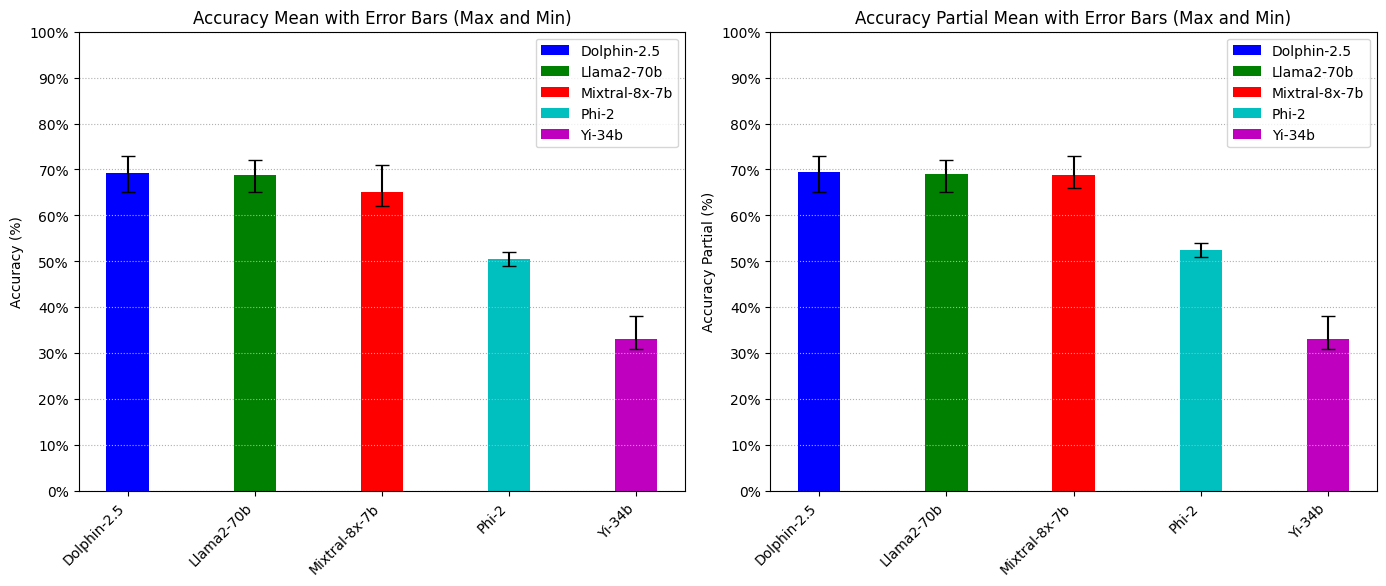

In [10]:
valid_question_answer = False  
#Create a dataframe with the size of NUM_OF_SHUFFLES which contains the dataframe llm_exam_result
shuffled_evalutation_df = pd.DataFrame(columns=[ 'Number of Questions','Correctly Answered','Incorrectly Answered','Accuracy','Accuracy Partial'])
questions  = pd.read_parquet('../data/mmlu_Computer_Security.parquet')
#Take the first 20 questions
#questions = questions.head(20)

#questions = extract_answer_from_text_file("../data/questionbank_cisco_CCNP.txt")
callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])
prompt_template = PromptTemplate.from_template(FEW_SHOT_TEMPLATE_MMLU)

#Iterate over each model definied in the MODEL_PATH dictionary
for model, model_path in MODEL_PATH.items():
     #Load the model wiht LLamaCpp
    llm = LlamaCpp(
        model_path= model_path,
        n_gpu_layers=128,
        n_batch=512,
        n_ctx=1100,
        temperature=1,
        top_p=0.9,
        #max_tokens = 100,
        #callback_manager=callback_manager,
        verbose=False,  # Verbose is required to pass to the callback manager
    )

    chain = prompt_template | llm
    for shuffled_iteration in range(NUM_OF_SHUFFLES):
        llm_exam_result = pd.DataFrame(columns = ["Model", "QuestionIndex", "SamplingIndex", "NumberOfCorrectLLMAnswers", "NumberOfCorrectExamAnswers", "Ratio", "LLM_Answer", "Exam_Answers", "Answered_Correctly",  "Too_Many_answers"]) 
        #Iterate over each question in the question dataframe
        for index_question, row in questions.iterrows():
            question = row['question']
            choices = row['choices']
            answers = row['answer']
            num_of_correct_answer = len(answers)

            choices = format_choices_for_llm(choices)

            #Only if shuffle is enabled, shuffle the choices
            if shuffled_iteration > 0:
                choices, answers = shuffle_choices_and_update_answer(row['choices'], row['answer'])
                num_of_correct_answer = len(answers)
                choices = format_choices_for_llm(choices)
            #Empty the char_probabilities dictionary for each question
            char_probabilities = {}

            #Iterate over the maximum sampling rate
            for index_sampling in range(MAX_SAMPLING_RATE):
                # Invoke the chain with the question and choices
                llm_answer = chain.invoke({"Exam_Question" : row['question'], "Exam_Choices" : choices})            

                # Check if the answer is in the expected format
                if extract_answer(llm_answer) is not None:
                    # Extract the correct answers from the LLM answer and analyse the answer
                    num_of_correct_llm_answer, answerLLm, too_many_answers, answered_correctly = evaluation_sampling(llm_answer, answers, num_of_correct_answer)
                    #Save the current sampling index -- How of the question has been asked until the answer was in the correct format
                    sample_Index = index_sampling
                    valid_question_answer = True
                    break
            
            #Depending on the result of the answer, add the result to the dataframe
            if not valid_question_answer:
                new_row = pd.DataFrame({"Model": [model], "QuestionIndex": [index_question], "SamplingIndex": [-1], "NumberOfCorrectLLMAnswers": [0], "NumberOfCorrectExamAnswers": [num_of_correct_answer], "Ratio": [-1], "LLM_Answer": [llm_answer], "Exam_Answers": [answers]})
                llm_exam_result = pd.concat([llm_exam_result, new_row], ignore_index=True)
            else:
                new_row = pd.DataFrame({"Model": [model], "QuestionIndex": [index_question], "SamplingIndex": [sample_Index], "NumberOfCorrectLLMAnswers": [num_of_correct_llm_answer], "NumberOfCorrectExamAnswers": [num_of_correct_answer], "Ratio": [num_of_correct_llm_answer/num_of_correct_answer], "LLM_Answer": [answerLLm], "Exam_Answers": [answers], "Answered_Correctly" : [answered_correctly], "Too_Many_answers": [too_many_answers]})
                llm_exam_result = pd.concat([llm_exam_result, new_row], ignore_index=True)
                valid_question_answer = False
        answered_correctly = False
        #Concat the the dataframe returned by evaulation to one dataframe
        display(llm_exam_result)
        #llm_exam_result.to_pickle(f"../data/{model}_shuffled_{shuffled_iteration}_201_301.pkl")
        evaluation_df = evaluation(llm_exam_result)
        #Concat the evaluation dataframe to the complete dataframe
        shuffled_evalutation_df = pd.concat([shuffled_evalutation_df, evaluation_df], ignore_index=True)
        display(shuffled_evalutation_df)

#plot_evaluation(shuffled_evalutation_df)
model_statistics = calculate_model_statistics(shuffled_evalutation_df)
display(model_statistics)
plot_evaluation(model_statistics)
shuffled_evalutation_df.to_pickle(OUTPUT_EVALUATION_DETAILED)
model_statistics.to_pickle(OUTPUT_EVALUATION)


In [5]:
for model, model_path in MODEL_PATH.items():
    print(f"Model: {model}")
    for shuffled_iteration in range(NUM_OF_SHUFFLES):
        llm_exam_result = pd.read_pickle(f"../data/{model}_shuffled_{shuffled_iteration}_201_301.pkl")
        evaluation_df = evaluation(llm_exam_result)
        #Concat the evaluation dataframe to the complete dataframe
        shuffled_evalutation_df = pd.concat([shuffled_evalutation_df, evaluation_df], ignore_index=True)
model_statistics = calculate_model_statistics(shuffled_evalutation_df)
display(model_statistics)
plot_evaluation(model_statistics)
shuffled_evalutation_df.to_pickle(OUTPUT_EVALUATION_DETAILED)
model_statistics.to_pickle(OUTPUT_EVALUATION)

Model: Llama2-70b


FileNotFoundError: [Errno 2] No such file or directory: '../data/Llama2-70b_shuffled_0_201_301.pkl'